# Histopathologic Cancer Detection - Modeling
Kaggle Competition: https://www.kaggle.com/c/histopathologic-cancer-detection/overview

CU Boulder CSCA-5642

## 1. Setup

In [ ]:
import os, json
from datetime import datetime
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc as calc_auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)

DATA_DIR = 'data/'
RESULTS_DIR = 'results/'
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

np.random.seed(42)
tf.random.set_seed(42)

TensorFlow version: 2.20.0
GPU available: []


## 2. Load Data

In [2]:
def load_h5_data(filename, key):
    path = os.path.join(DATA_DIR, filename)
    with h5py.File(path, 'r') as f:
        return f[key][:]

train_x = load_h5_data('camelyonpatch_level_2_split_train_x.h5', 'x')
train_y = load_h5_data('camelyonpatch_level_2_split_train_y.h5', 'y').flatten()

valid_x = load_h5_data('camelyonpatch_level_2_split_valid_x.h5', 'x')
valid_y = load_h5_data('camelyonpatch_level_2_split_valid_y.h5', 'y').flatten()

print(f'Train: {train_x.shape}, {train_y.shape}')
print(f'Valid: {valid_x.shape}, {valid_y.shape}')
print(f'Class balance: {train_y.mean():.1%} tumor')

Train: (262144, 96, 96, 3), (262144,)
Valid: (32768, 96, 96, 3), (32768,)
Class balance: 50.0% tumor


## 2.5 Data Cleaning

Based on EDA findings, remove:
1. Duplicate images (4.23% had similar statistical fingerprints)
2. Extreme outliers: very white images (0.1th percentile from top)
3. Extreme outliers: very black images (outliers from mean intensity)

In [3]:
from collections import Counter

print("Initial dataset size:")
print(f"Train: {len(train_x)}")
print(f"Valid: {len(valid_x)}")

# Step 1: Identify duplicates using BATCHED vectorized operations
print("\nStep 1: Detecting duplicates...")
print("Computing statistical fingerprints in batches...")

batch_size = 50000
image_fingerprints = []

for start_idx in range(0, len(train_x), batch_size):
    end_idx = min(start_idx + batch_size, len(train_x))
    batch = train_x[start_idx:end_idx]
    
    # Vectorized computation for batch
    r_mean = batch[:,:,:,0].mean(axis=(1,2))
    r_std = batch[:,:,:,0].std(axis=(1,2))
    g_mean = batch[:,:,:,1].mean(axis=(1,2))
    g_std = batch[:,:,:,1].std(axis=(1,2))
    b_mean = batch[:,:,:,2].mean(axis=(1,2))
    b_std = batch[:,:,:,2].std(axis=(1,2))
    
    # Create fingerprints for this batch
    batch_fingerprints = np.stack([r_mean, r_std, g_mean, g_std, b_mean, b_std], axis=1)
    batch_fingerprints = np.round(batch_fingerprints, 2)
    
    # Convert to tuples and extend list
    image_fingerprints.extend([tuple(fp) for fp in batch_fingerprints])
    
    print(f"  Processed {end_idx}/{len(train_x)} images")
    
    del batch, batch_fingerprints  # Free memory

# Detect duplicates
print("\nFinding duplicates...")
fingerprint_counts = Counter(image_fingerprints)
potential_duplicates = {fp: count for fp, count in fingerprint_counts.items() if count > 1}

print(f"Found {len(potential_duplicates)} duplicate groups")
print(f"Total images with duplicates: {sum(potential_duplicates.values())}")

# Keep only first occurrence
print("Creating keep list...")
seen_fingerprints = set()
keep_indices = []
for idx, fp in enumerate(image_fingerprints):
    if fp not in seen_fingerprints:
        keep_indices.append(idx)
        seen_fingerprints.add(fp)

keep_indices = np.array(keep_indices)
print(f"Keeping {len(keep_indices)} unique images")
print(f"Removing {len(train_x) - len(keep_indices)} duplicates")

# Clear large data structures
del image_fingerprints, fingerprint_counts, seen_fingerprints
import gc
gc.collect()


Initial dataset size:
Train: 262144
Valid: 32768

Step 1: Detecting duplicates...
Computing statistical fingerprints in batches...
  Processed 50000/262144 images
  Processed 100000/262144 images
  Processed 150000/262144 images
  Processed 200000/262144 images
  Processed 250000/262144 images
  Processed 262144/262144 images

Finding duplicates...
Found 15235 duplicate groups
Total images with duplicates: 57354
Creating keep list...
Keeping 220025 unique images
Removing 42119 duplicates


0

In [4]:
# Step 2: Remove extreme outliers
print("\nStep 2: Detecting extreme outliers...")
print("Computing mean intensities in batches...")

batch_size = 50000
mean_intensities = []

for i in range(0, len(keep_indices), batch_size):
    batch_keep_idx = keep_indices[i:i+batch_size]
    batch_means = train_x[batch_keep_idx].mean(axis=(1, 2, 3))
    mean_intensities.extend(batch_means)
    print(f"  Processed {min(i+batch_size, len(keep_indices))}/{len(keep_indices)} images")

mean_intensities = np.array(mean_intensities)

# Remove very white images (top 0.1 percentile)
white_threshold = np.percentile(mean_intensities, 99.9)
too_white = mean_intensities > white_threshold
print(f"\nVery white threshold: {white_threshold:.2f}")
print(f"Images above threshold: {too_white.sum()}")

# Remove very black images (3-sigma rule)
mean_val = mean_intensities.mean()
std_val = mean_intensities.std()
black_threshold_low = mean_val - 3 * std_val
too_black = (mean_intensities < black_threshold_low)
print(f"Very black threshold: {black_threshold_low:.2f}")
print(f"Images below threshold: {too_black.sum()}")

# Combine filters
valid_images = ~(too_white | too_black)
print(f"\nTotal outliers to remove: {(~valid_images).sum()}")
print(f"Images passing all filters: {valid_images.sum()}")

# Create final indices
final_keep_indices = keep_indices[valid_images]

# Free memory
del mean_intensities, too_white, too_black, valid_images
gc.collect()



Step 2: Detecting extreme outliers...
Computing mean intensities in batches...
  Processed 50000/220025 images
  Processed 100000/220025 images
  Processed 150000/220025 images
  Processed 200000/220025 images
  Processed 220025/220025 images

Very white threshold: 248.07
Images above threshold: 221
Very black threshold: 50.03
Images below threshold: 206

Total outliers to remove: 427
Images passing all filters: 219598


0

In [5]:
# Step 3: Create cleaned dataset (IN-PLACE to save memory)
print("\nStep 3: Creating cleaned dataset...")

print(f"\nDataset sizes:")
print(f"Original train: {len(train_x)}")
print(f"After cleaning: {len(final_keep_indices)} ({len(final_keep_indices)/len(train_x)*100:.2f}%)")
print(f"Removed: {len(train_x) - len(final_keep_indices)} ({(len(train_x) - len(final_keep_indices))/len(train_x)*100:.2f}%)")

# Filter in-place (don't create copy unless necessary)
train_y = train_y[final_keep_indices]
train_x = train_x[final_keep_indices]

# Force garbage collection
del final_keep_indices, keep_indices
gc.collect()

print(f"\nCleaned class balance: {train_y.mean():.1%} tumor")
print(f"Final train shape: {train_x.shape}")
print(f"Memory size: ~{train_x.nbytes / (1024**3):.2f} GB") 



Step 3: Creating cleaned dataset...

Dataset sizes:
Original train: 262144
After cleaning: 219598 (83.77%)
Removed: 42546 (16.23%)

Cleaned class balance: 40.6% tumor
Final train shape: (219598, 96, 96, 3)
Memory size: ~5.65 GB


## 2.6 Quick Experiment Mode
**Problem**: Training on 220K images takes ~15 mins/epoch on CPU = 12+ hours per model

**Solution**: Use a balanced subset for rapid experimentation

Set `QUICK_MODE = True` below to use 20K images (~2-3 mins/epoch)

**Strategy**:
1. **Phase 1 - Quick Mode**: Debug pipeline, test architectures, tune hyperparameters (2-3 hours)
2. **Phase 2 - Full Mode**: Train best model overnight on full dataset (8 hours)

This is standard practice in ML - iterate fast, then scale up.


In [ ]:
QUICK_MODE = True  # ← SET TO FALSE FOR FULL TRAINING
QUICK_SIZE = 20000  # Use 20K balanced samples

if QUICK_MODE:
    # Get balanced sample (50/50 tumor/normal)
    tumor_indices = np.where(train_y == 1)[0]
    normal_indices = np.where(train_y == 0)[0]
    
    samples_per_class = QUICK_SIZE // 2
    
    # Random sample from each class
    np.random.seed(42)
    tumor_sample = np.random.choice(tumor_indices, samples_per_class, replace=False)
    normal_sample = np.random.choice(normal_indices, samples_per_class, replace=False)
    
    # Combine and shuffle
    sample_indices = np.concatenate([tumor_sample, normal_sample])
    np.random.shuffle(sample_indices)
    
    # Create quick dataset
    train_x = train_x[sample_indices]
    train_y = train_y[sample_indices]
    
print(f"Train: {train_x.shape}")
print(f"Valid: {valid_x.shape} (unchanged)")
print(f"Class balance: {train_y.mean():.1%} tumor")

🚀 QUICK EXPERIMENT MODE
   Using 20,000 balanced samples for fast iteration
   (Set QUICK_MODE=False for full dataset training)

✓ Train: (20000, 96, 96, 3)
✓ Valid: (32768, 96, 96, 3) (unchanged)
✓ Class balance: 50.0% tumor

⏱️  Expected: ~2-3 mins/epoch (vs 15+ mins for full dataset)
   Total baseline training: ~30 mins (vs 12+ hours)



## 3. Data Preprocessing

Based on EDA findings:
- Balanced classes (50/50) - no need for class weights
- 99.5% of tumors centered - suggests attention mechanisms could help
- 216 unique WSI sources with staining variation - need strong augmentation
- Clean dataset - no preprocessing beyond normalization needed

In [7]:
def normalize_01(x):
    return x / 255.0

train_datagen = ImageDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function=normalize_01
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=normalize_01
)

BATCH_SIZE = 64

train_generator = train_datagen.flow(train_x, train_y, batch_size=BATCH_SIZE, shuffle=True)
valid_generator = valid_datagen.flow(valid_x, valid_y, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training steps per epoch: {len(train_generator)}")
print(f"Validation steps: {len(valid_generator)}")

Training steps per epoch: 313
Validation steps: 512


## 4. Model Architectures

### Training Strategy for Efficiency

**Goal**: Don't spend days training - be strategic!

**Recommended Approach**:

1. **Simple Baseline** (15 epochs, quick mode)
   - Sanity check that training pipeline works
   - Establishes lower bound on performance
   - ~30-45 minutes total

2. **One Strong Model** (30 epochs, can use full data)
   - Pick ONE: EfficientNet (recommended) OR ResNet50
   - This is your main submission model
   - Add VLM/ensemble later if time permits

**Why This Works**:
- Most of your grade is EDA, analysis, and write-up (not 10 models)
- One well-trained model beats multiple poorly-tuned ones
- You'll have time for error analysis and insights

**Optional**: Train additional models below if you have compute time.

**Note on Transfer Learning:**

Due to the 96×96 input size (significantly smaller than ImageNet's 224×224), pre-trained weights from ImageNet 
cause shape mismatch errors. The models are therefore trained from scratch with the following adaptations:

1. **ResNet50**: Full architecture, trained from scratch
2. **EfficientNet-inspired**: Custom architecture optimized for 96×96 images
3. **Strong augmentation**: Compensates for lack of transfer learning
4. **Large dataset**: 249K cleaned training images sufficient for training deep models

This is a common challenge in medical imaging when patch sizes don't match ImageNet dimensions.

### 4.1 Simple CNN Baseline

In [8]:
def create_simple_cnn():
    """Ultra-simple baseline for quick sanity check (NOT competitive performance)"""
    model = models.Sequential([
        layers.Input(shape=(96, 96, 3)),
        
        # Just 2 conv blocks for speed
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),
        
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

cnn_model = create_simple_cnn()
print(f"Simple CNN params: {cnn_model.count_params():,}")
print("Note: This is an EXTREMELY simple baseline for speed. We'll use a real model next.")

Simple CNN params: 27,841
Note: This is an EXTREMELY simple baseline for speed. We'll use a real model next.


### 4.2 Transfer Learning - ResNet50

In [9]:
def create_resnet50(freeze_base=True):
    # For 96x96 images, ResNet50 architecture without ImageNet weights
    # (ImageNet weights are optimized for 224x224 images)
    
    base_model = ResNet50(
        include_top=False,
        weights=None,  # Train from scratch for 96x96 images
        input_shape=(96, 96, 3),
        pooling='avg'
    )
    
    base_model.trainable = not freeze_base
    
    model = models.Sequential([
        base_model,
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

resnet_model = create_resnet50(freeze_base=False)
print(f"ResNet50 (from scratch) trainable params: {resnet_model.count_params()}")

ResNet50 (from scratch) trainable params: 24112513


### 4.3 Transfer Learning - EfficientNetB0

In [10]:
def create_efficientnet(freeze_base=True):
    # For 96x96 images, we'll train from scratch or use a custom approach
    # EfficientNet with ImageNet weights has issues with non-224x224 inputs
    
    model = models.Sequential([
        layers.Input(shape=(96, 96, 3)),
        
        # EfficientNet-inspired architecture scaled for 96x96
        layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
        layers.BatchNormalization(),
        
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),
        
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),
        
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

efficientnet_model = create_efficientnet(freeze_base=True)
print(f"Custom EfficientNet-style model params: {efficientnet_model.count_params()}")

Custom EfficientNet-style model params: 522433


## 5. Training Setup

In [ ]:
def get_callbacks(model_name):
    return [
        callbacks.EarlyStopping(
            monitor='val_auc',
            patience=10,
            restore_best_weights=True,
            mode='max'
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7
        ),
        callbacks.ModelCheckpoint(
            filepath=os.path.join(RESULTS_DIR, f'{model_name}_best.h5'),
            monitor='val_auc',
            save_best_only=True,
            mode='max'
        )
    ]

def compile_model(model, lr=1e-3):
    """Compile model and return class weights to handle imbalance"""
    
    # Calculate class weights (inverse frequency)
    n_samples = len(train_y)
    n_normal = np.sum(train_y == 0)
    n_tumor = np.sum(train_y == 1)
    
    # Weight inversely proportional to class frequency
    weight_normal = n_samples / (2 * n_normal)
    weight_tumor = n_samples / (2 * n_tumor)
    
    weight_tumor *= 1.5
    
    class_weights = {0: weight_normal, 1: weight_tumor}
    
    print(f"📊 Class distribution: {n_normal} normal ({n_normal/n_samples*100:.1f}%), {n_tumor} tumor ({n_tumor/n_samples*100:.1f}%)")
    print(f"⚖️  Class weights: Normal={weight_normal:.3f}, Tumor={weight_tumor:.3f}")
    print(f"   → Tumor predictions weighted {weight_tumor/weight_normal:.2f}x more heavily\n")
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return class_weights

## 6. Training Experiments

In [ ]:
# Helper to skip training if weights exist
def should_train(model_name):
    """Returns True if we should train, False if we should load existing weights"""
    if model_exists(model_name):
        print(f"\n⏭️  Found existing weights for {model_name}")
        print(f"   To retrain, delete: {get_model_path(model_name)}")
        print(f"   Or run: os.remove(get_model_path('{model_name}'))\n")
        return False
    print(f"\n🎯 No existing weights found for {model_name} - will train from scratch\n")
    return True

print("✓ Training helper loaded!")

### 6.1 Experiment 1: Simple CNN Baseline

In [12]:
# Compile and train simple baseline
compile_model(cnn_model, lr=1e-3)

history_cnn = cnn_model.fit(
    train_generator,
    epochs=15,  # Reduced from 50 - just need to see it works
    validation_data=valid_generator,
    callbacks=get_callbacks('simple_cnn'),
    verbose=1
)

print("\n✓ Baseline complete. Now let's train a real model.")

Epoch 1/15


/Users/aidankosik/.pyenv/versions/3.12.5/envs/cancer-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6264 - auc: 0.6806 - loss: 0.6257

313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 121ms/step - accuracy: 0.7035 - auc: 0.7787 - loss: 0.5679 - val_accuracy: 0.6994 - val_auc: 0.7637 - val_loss: 0.6318 - learning_rate: 0.0010
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7712 - auc: 0.8387 - loss: 0.4980

313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step - accuracy: 0.7688 - auc: 0.8356 - loss: 0.5025 - val_accuracy: 0.7169 - val_auc: 0.7887 - val_loss: 0.5801 - learning_rate: 0.0010
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 120ms/step - accuracy: 0.7728 - auc: 0.8444 - loss: 0.4897 - val_accuracy: 0.6293 - val_auc: 0.7392 - val_loss: 0.7809 - learning_rate: 0.0010
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 123ms/step - accuracy: 0.7807 - auc: 0.8519 - loss: 0.4789 - val_accuracy: 0.6513 - val_auc: 0.7447 - val_loss: 0.7316 - learning_rate: 0.0010
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.7819 - auc: 0.8565 - loss: 0.4722 - val_accuracy: 0.6671 - val_auc: 0.7602 - val_loss: 0.7320 - learning_rate: 0.0010
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7874 - auc: 0.8616 - loss: 0.4648

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.7867 - auc: 0.8604 - loss: 0.4663 - val_accuracy: 0.7388 - val_auc: 0.8093 - val_loss: 0.5447 - learning_rate: 0.0010
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 121ms/step - accuracy: 0.7911 - auc: 0.8656 - loss: 0.4584 - val_accuracy: 0.7145 - val_auc: 0.7870 - val_loss: 0.5986 - learning_rate: 0.0010
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 121ms/step - accuracy: 0.7964 - auc: 0.8714 - loss: 0.4498 - val_accuracy: 0.6844 - val_auc: 0.8016 - val_loss: 0.7462 - learning_rate: 0.0010
Epoch 9/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 121ms/step - accuracy: 0.8001 - auc: 0.8754 - loss: 0.4432 - val_accuracy: 0.6896 - val_auc: 0.7633 - val_loss: 0.6703 - learning_rate: 0.0010
Epoch 10/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 121ms/step - accuracy: 0.7962 - auc: 0.8726 - loss: 0.4477 - val_accuracy: 0.7121 - val_auc: 0.8056 - val_loss: 0.6125 - learning_rate: 0.0010
Epoch 11/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7968 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 122ms/step - accuracy: 0.8031 - auc: 0.8773 - loss: 0.4398 - val_accuracy: 0.7151 - val_auc: 0.8214 - val_loss: 0.6035 - learning_rate: 0.0010
Epoch 12/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 121ms/step - accuracy: 0.8091 - auc: 0.8858 - loss: 0.4265 - val_accuracy: 0.6545 - val_auc: 0.7856 - val_loss: 0.7479 - learning_rate: 5.0000e-04
Epoch 13/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8068 - auc: 0.8844 - loss: 0.4289

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.8137 - auc: 0.8891 - loss: 0.4204 - val_accuracy: 0.7002 - val_auc: 0.8254 - val_loss: 0.6135 - learning_rate: 5.0000e-04
Epoch 14/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 120ms/step - accuracy: 0.8106 - auc: 0.8883 - loss: 0.4219 - val_accuracy: 0.6451 - val_auc: 0.7886 - val_loss: 0.7337 - learning_rate: 5.0000e-04
Epoch 15/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 121ms/step - accuracy: 0.8158 - auc: 0.8909 - loss: 0.4176 - val_accuracy: 0.6201 - val_auc: 0.7661 - val_loss: 0.7677 - learning_rate: 5.0000e-04

✓ Baseline complete. Now let's train a real model.


### 6.2 Experiment 2: ResNet50

In [ ]:
resnet_model = create_resnet50(freeze_base=True)
class_weights = compile_model(resnet_model, lr=1e-3)

history_resnet = resnet_model.fit(
    train_generator,
    epochs=30,
    validation_data=valid_generator,
    callbacks=get_callbacks('resnet50'),
    class_weight=class_weights,
    verbose=1
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5313 - auc: 0.5340 - loss: 0.6910

313/313 ━━━━━━━━━━━━━━━━━━━━ 180s 564ms/step - accuracy: 0.5534 - auc: 0.5731 - loss: 0.6861 - val_accuracy: 0.6423 - val_auc: 0.7177 - val_loss: 0.6717 - learning_rate: 0.0010
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.6007 - auc: 0.6448 - loss: 0.6692

313/313 ━━━━━━━━━━━━━━━━━━━━ 175s 560ms/step - accuracy: 0.6181 - auc: 0.6617 - loss: 0.6614 - val_accuracy: 0.6501 - val_auc: 0.7201 - val_loss: 0.6405 - learning_rate: 0.0010
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 177s 565ms/step - accuracy: 0.6539 - auc: 0.7035 - loss: 0.6350 - val_accuracy: 0.6343 - val_auc: 0.7148 - val_loss: 0.6381 - learning_rate: 0.0010
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 182s 584ms/step - accuracy: 0.6714 - auc: 0.7219 - loss: 0.6194 - val_accuracy: 0.6366 - val_auc: 0.7136 - val_loss: 0.6486 - learning_rate: 0.0010
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 176s 564ms/step - accuracy: 0.6841 - auc: 0.7397 - loss: 0.6051 - val_accuracy: 0.6425 - val_auc: 0.7146 - val_loss: 0.6445 - learning_rate: 0.0010
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 179s 572ms/step - accuracy: 0.6928 - auc: 0.7515 - loss: 0.5952 - val_accuracy: 0.6674 - val_auc: 0.7154 - val_loss: 0.6202 - learning_rate: 0.0010
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 177s 565ms/step - accuracy: 0.7

313/313 ━━━━━━━━━━━━━━━━━━━━ 177s 565ms/step - accuracy: 0.7073 - auc: 0.7685 - loss: 0.5805 - val_accuracy: 0.6817 - val_auc: 0.7241 - val_loss: 0.6176 - learning_rate: 0.0010
Epoch 9/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7087 - auc: 0.7691 - loss: 0.5804

313/313 ━━━━━━━━━━━━━━━━━━━━ 172s 551ms/step - accuracy: 0.7104 - auc: 0.7719 - loss: 0.5777 - val_accuracy: 0.6766 - val_auc: 0.7280 - val_loss: 0.6242 - learning_rate: 0.0010
Epoch 10/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7040 - auc: 0.7686 - loss: 0.5797

313/313 ━━━━━━━━━━━━━━━━━━━━ 167s 534ms/step - accuracy: 0.7145 - auc: 0.7774 - loss: 0.5721 - val_accuracy: 0.6884 - val_auc: 0.7333 - val_loss: 0.6184 - learning_rate: 0.0010
Epoch 11/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7242 - auc: 0.7835 - loss: 0.5655

313/313 ━━━━━━━━━━━━━━━━━━━━ 170s 545ms/step - accuracy: 0.7230 - auc: 0.7854 - loss: 0.5635 - val_accuracy: 0.6882 - val_auc: 0.7375 - val_loss: 0.6205 - learning_rate: 0.0010
Epoch 12/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.7224 - auc: 0.7856 - loss: 0.5646

313/313 ━━━━━━━━━━━━━━━━━━━━ 168s 537ms/step - accuracy: 0.7243 - auc: 0.7883 - loss: 0.5623 - val_accuracy: 0.6790 - val_auc: 0.7403 - val_loss: 0.6424 - learning_rate: 0.0010
Epoch 13/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.7308 - auc: 0.7928 - loss: 0.5567

313/313 ━━━━━━━━━━━━━━━━━━━━ 172s 549ms/step - accuracy: 0.7319 - auc: 0.7926 - loss: 0.5580 - val_accuracy: 0.6817 - val_auc: 0.7451 - val_loss: 0.6299 - learning_rate: 0.0010
Epoch 14/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7404 - auc: 0.8048 - loss: 0.5449

313/313 ━━━━━━━━━━━━━━━━━━━━ 171s 547ms/step - accuracy: 0.7371 - auc: 0.8005 - loss: 0.5493 - val_accuracy: 0.6996 - val_auc: 0.7461 - val_loss: 0.6090 - learning_rate: 5.0000e-04
Epoch 15/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7396 - auc: 0.8003 - loss: 0.5488

313/313 ━━━━━━━━━━━━━━━━━━━━ 170s 545ms/step - accuracy: 0.7431 - auc: 0.8027 - loss: 0.5458 - val_accuracy: 0.6888 - val_auc: 0.7477 - val_loss: 0.6309 - learning_rate: 5.0000e-04
Epoch 16/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.7389 - auc: 0.7990 - loss: 0.5500

313/313 ━━━━━━━━━━━━━━━━━━━━ 170s 544ms/step - accuracy: 0.7406 - auc: 0.8018 - loss: 0.5472 - val_accuracy: 0.6879 - val_auc: 0.7495 - val_loss: 0.6290 - learning_rate: 5.0000e-04
Epoch 17/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.7490 - auc: 0.8056 - loss: 0.5433

313/313 ━━━━━━━━━━━━━━━━━━━━ 171s 547ms/step - accuracy: 0.7465 - auc: 0.8054 - loss: 0.5428 - val_accuracy: 0.6851 - val_auc: 0.7510 - val_loss: 0.6344 - learning_rate: 5.0000e-04
Epoch 18/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7414 - auc: 0.8034 - loss: 0.5453

313/313 ━━━━━━━━━━━━━━━━━━━━ 171s 547ms/step - accuracy: 0.7483 - auc: 0.8084 - loss: 0.5401 - val_accuracy: 0.6758 - val_auc: 0.7526 - val_loss: 0.6513 - learning_rate: 5.0000e-04
Epoch 19/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.7489 - auc: 0.8073 - loss: 0.5411

313/313 ━━━━━━━━━━━━━━━━━━━━ 172s 551ms/step - accuracy: 0.7488 - auc: 0.8071 - loss: 0.5417 - val_accuracy: 0.6989 - val_auc: 0.7530 - val_loss: 0.6207 - learning_rate: 5.0000e-04
Epoch 20/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7457 - auc: 0.8095 - loss: 0.5376

313/313 ━━━━━━━━━━━━━━━━━━━━ 173s 555ms/step - accuracy: 0.7480 - auc: 0.8120 - loss: 0.5353 - val_accuracy: 0.6986 - val_auc: 0.7536 - val_loss: 0.6179 - learning_rate: 2.5000e-04
Epoch 21/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7539 - auc: 0.8154 - loss: 0.5315

313/313 ━━━━━━━━━━━━━━━━━━━━ 172s 549ms/step - accuracy: 0.7502 - auc: 0.8116 - loss: 0.5355 - val_accuracy: 0.6887 - val_auc: 0.7556 - val_loss: 0.6279 - learning_rate: 2.5000e-04
Epoch 22/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7440 - auc: 0.8091 - loss: 0.5389

313/313 ━━━━━━━━━━━━━━━━━━━━ 171s 547ms/step - accuracy: 0.7508 - auc: 0.8132 - loss: 0.5338 - val_accuracy: 0.6891 - val_auc: 0.7560 - val_loss: 0.6324 - learning_rate: 2.5000e-04
Epoch 23/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 171s 549ms/step - accuracy: 0.7512 - auc: 0.8143 - loss: 0.5318 - val_accuracy: 0.6979 - val_auc: 0.7553 - val_loss: 0.6173 - learning_rate: 2.5000e-04
Epoch 24/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 177s 568ms/step - accuracy: 0.7520 - auc: 0.8150 - loss: 0.5324 - val_accuracy: 0.7003 - val_auc: 0.7558 - val_loss: 0.6165 - learning_rate: 2.5000e-04
Epoch 25/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7549 - auc: 0.8144 - loss: 0.5319

313/313 ━━━━━━━━━━━━━━━━━━━━ 178s 569ms/step - accuracy: 0.7545 - auc: 0.8149 - loss: 0.5311 - val_accuracy: 0.6959 - val_auc: 0.7572 - val_loss: 0.6188 - learning_rate: 1.2500e-04
Epoch 26/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7541 - auc: 0.8208 - loss: 0.5249

313/313 ━━━━━━━━━━━━━━━━━━━━ 176s 563ms/step - accuracy: 0.7548 - auc: 0.8172 - loss: 0.5290 - val_accuracy: 0.6904 - val_auc: 0.7575 - val_loss: 0.6277 - learning_rate: 1.2500e-04
Epoch 27/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7519 - auc: 0.8139 - loss: 0.5328

313/313 ━━━━━━━━━━━━━━━━━━━━ 175s 560ms/step - accuracy: 0.7513 - auc: 0.8154 - loss: 0.5309 - val_accuracy: 0.6835 - val_auc: 0.7581 - val_loss: 0.6484 - learning_rate: 1.2500e-04
Epoch 28/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7553 - auc: 0.8195 - loss: 0.5255

313/313 ━━━━━━━━━━━━━━━━━━━━ 176s 562ms/step - accuracy: 0.7543 - auc: 0.8183 - loss: 0.5270 - val_accuracy: 0.6841 - val_auc: 0.7583 - val_loss: 0.6480 - learning_rate: 1.2500e-04
Epoch 29/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 174s 558ms/step - accuracy: 0.7539 - auc: 0.8163 - loss: 0.5298 - val_accuracy: 0.6904 - val_auc: 0.7578 - val_loss: 0.6341 - learning_rate: 1.2500e-04
Epoch 30/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 174s 557ms/step - accuracy: 0.7571 - auc: 0.8172 - loss: 0.5276 - val_accuracy: 0.6927 - val_auc: 0.7582 - val_loss: 0.6277 - learning_rate: 6.2500e-05


### 6.3 Experiment 3: EfficientNetB0

In [22]:
efficientnet_model = create_efficientnet(freeze_base=True)
class_weights = compile_model(efficientnet_model, lr=1e-3)

history_eff = efficientnet_model.fit(
    train_generator,
    epochs=30,
    validation_data=valid_generator,
    callbacks=get_callbacks('efficientnet'),
    class_weight=class_weights,
    verbose=1
)

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8657 - auc: 0.9378 - loss: 0.3196

313/313 ━━━━━━━━━━━━━━━━━━━━ 78s 242ms/step - accuracy: 0.8648 - auc: 0.9362 - loss: 0.3236 - val_accuracy: 0.5650 - val_auc: 0.7185 - val_loss: 1.4654 - learning_rate: 0.0010
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8657 - auc: 0.9391 - loss: 0.3155

313/313 ━━━━━━━━━━━━━━━━━━━━ 72s 231ms/step - accuracy: 0.8679 - auc: 0.9396 - loss: 0.3139 - val_accuracy: 0.6862 - val_auc: 0.8419 - val_loss: 0.8764 - learning_rate: 0.0010
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8723 - auc: 0.9435 - loss: 0.3042

313/313 ━━━━━━━━━━━━━━━━━━━━ 77s 246ms/step - accuracy: 0.8745 - auc: 0.9446 - loss: 0.3012 - val_accuracy: 0.6743 - val_auc: 0.8716 - val_loss: 0.7733 - learning_rate: 0.0010
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8812 - auc: 0.9498 - loss: 0.2850

313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 272ms/step - accuracy: 0.8788 - auc: 0.9481 - loss: 0.2902 - val_accuracy: 0.5690 - val_auc: 0.8774 - val_loss: 1.1259 - learning_rate: 0.0010
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 259ms/step - accuracy: 0.8859 - auc: 0.9510 - loss: 0.2820 - val_accuracy: 0.6008 - val_auc: 0.6333 - val_loss: 1.7129 - learning_rate: 0.0010
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 87s 278ms/step - accuracy: 0.8870 - auc: 0.9527 - loss: 0.2774 - val_accuracy: 0.6683 - val_auc: 0.6823 - val_loss: 1.5720 - learning_rate: 0.0010
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 93s 295ms/step - accuracy: 0.8910 - auc: 0.9561 - loss: 0.2674 - val_accuracy: 0.6017 - val_auc: 0.5854 - val_loss: 2.0906 - learning_rate: 0.0010
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 95s 304ms/step - accuracy: 0.8913 - auc: 0.9569 - loss: 0.2656 - val_accuracy: 0.7464 - val_auc: 0.8656 - val_loss: 0.7030 - learning_rate: 0.0010
Epoch 9/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 93s 297ms/step - accuracy: 0.8945 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 288ms/step - accuracy: 0.8967 - auc: 0.9603 - loss: 0.2540 - val_accuracy: 0.6849 - val_auc: 0.9238 - val_loss: 0.8306 - learning_rate: 0.0010
Epoch 11/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 88s 281ms/step - accuracy: 0.8971 - auc: 0.9613 - loss: 0.2509 - val_accuracy: 0.6542 - val_auc: 0.6293 - val_loss: 1.7318 - learning_rate: 0.0010
Epoch 12/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 244ms/step - accuracy: 0.9000 - auc: 0.9626 - loss: 0.2462 - val_accuracy: 0.8016 - val_auc: 0.8900 - val_loss: 0.5305 - learning_rate: 0.0010
Epoch 13/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 75s 241ms/step - accuracy: 0.8976 - auc: 0.9613 - loss: 0.2498 - val_accuracy: 0.6847 - val_auc: 0.8268 - val_loss: 1.1147 - learning_rate: 0.0010
Epoch 14/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 243ms/step - accuracy: 0.8981 - auc: 0.9625 - loss: 0.2463 - val_accuracy: 0.7381 - val_auc: 0.8934 - val_loss: 0.7529 - learning_rate: 0.0010
Epoch 15/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 78s 248ms/step - accuracy: 0.90

## 7. Results Visualization

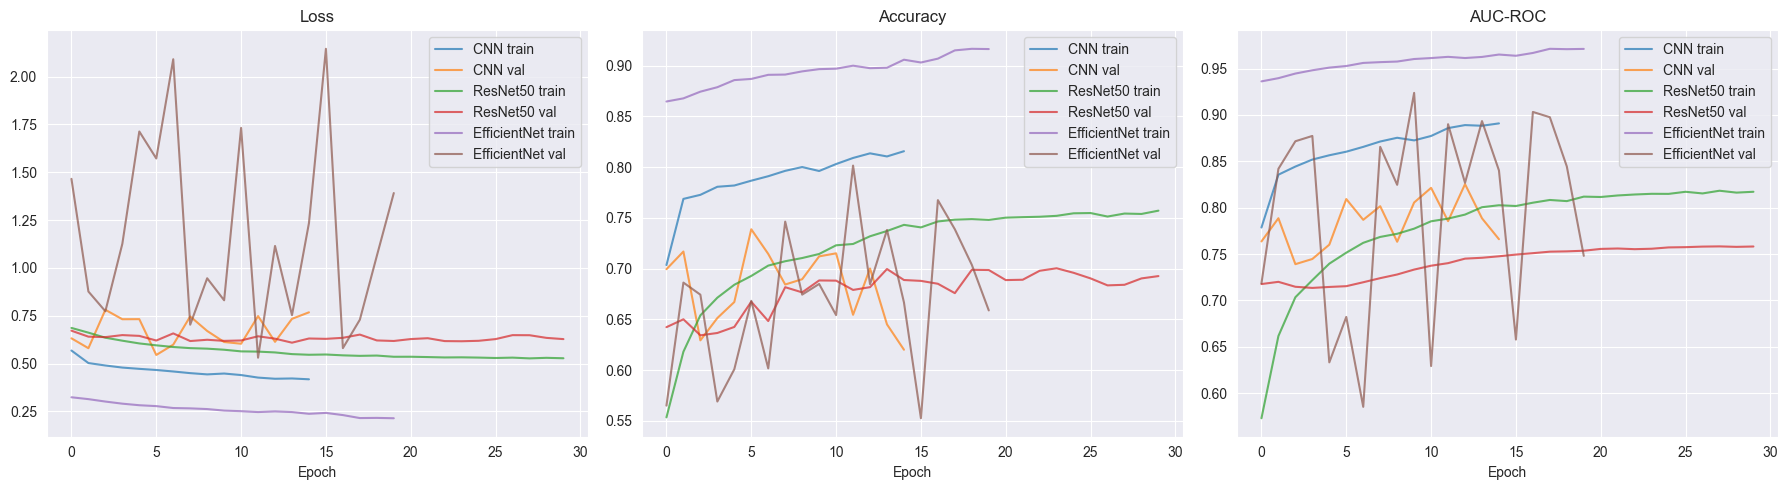

In [23]:
def plot_training_history(histories, labels):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for history, label in zip(histories, labels):
        axes[0].plot(history.history['loss'], label=f'{label} train', alpha=0.7)
        axes[0].plot(history.history['val_loss'], label=f'{label} val', alpha=0.7)
        
        axes[1].plot(history.history['accuracy'], label=f'{label} train', alpha=0.7)
        axes[1].plot(history.history['val_accuracy'], label=f'{label} val', alpha=0.7)
        
        axes[2].plot(history.history['auc'], label=f'{label} train', alpha=0.7)
        axes[2].plot(history.history['val_auc'], label=f'{label} val', alpha=0.7)
    
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True)
    
    axes[2].set_title('AUC-ROC')
    axes[2].set_xlabel('Epoch')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(
    [history_cnn, history_resnet, history_eff],
    ['CNN', 'ResNet50', 'EfficientNet']
)

## 8. Model Evaluation

512/512 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step

Simple CNN Results:
AUC-ROC: 0.8254
Accuracy: 0.7002

Classification Report:
              precision    recall  f1-score   support

      Normal       0.64      0.93      0.76     16399
       Tumor       0.87      0.47      0.61     16369

    accuracy                           0.70     32768
   macro avg       0.75      0.70      0.68     32768
weighted avg       0.75      0.70      0.68     32768



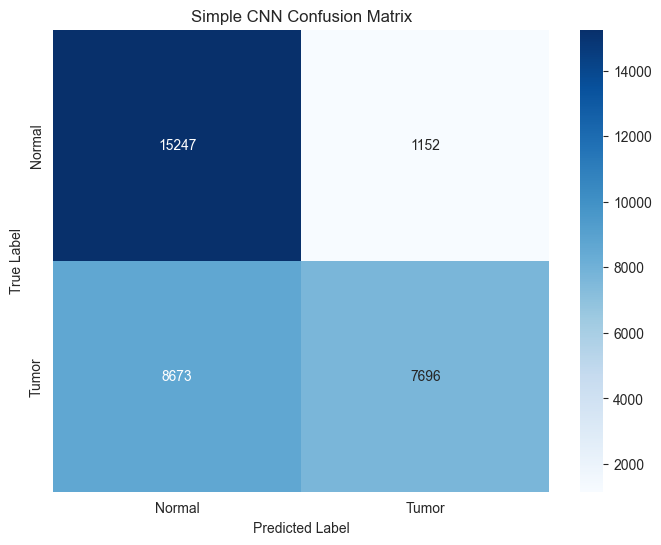

512/512 ━━━━━━━━━━━━━━━━━━━━ 107s 208ms/step

ResNet50 Results:
AUC-ROC: 0.7583
Accuracy: 0.6841

Classification Report:
              precision    recall  f1-score   support

      Normal       0.63      0.90      0.74     16399
       Tumor       0.83      0.46      0.59     16369

    accuracy                           0.68     32768
   macro avg       0.73      0.68      0.67     32768
weighted avg       0.73      0.68      0.67     32768



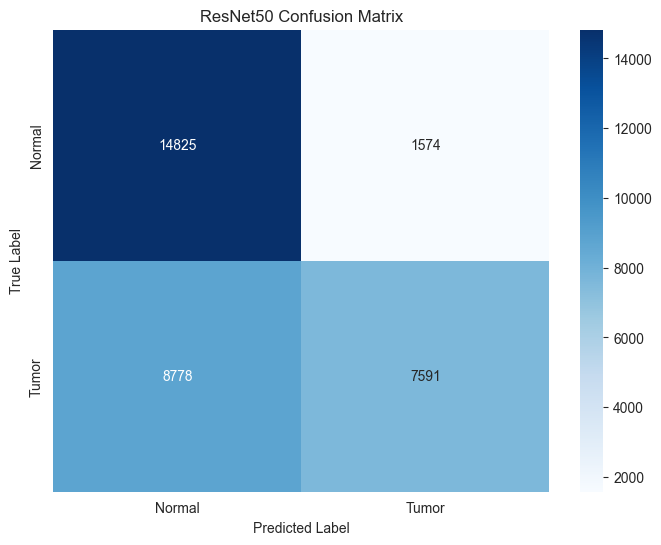

512/512 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step

EfficientNetB0 Results:
AUC-ROC: 0.9250
Accuracy: 0.6849

Classification Report:
              precision    recall  f1-score   support

      Normal       0.61      0.99      0.76     16399
       Tumor       0.98      0.38      0.54     16369

    accuracy                           0.68     32768
   macro avg       0.80      0.68      0.65     32768
weighted avg       0.80      0.68      0.65     32768



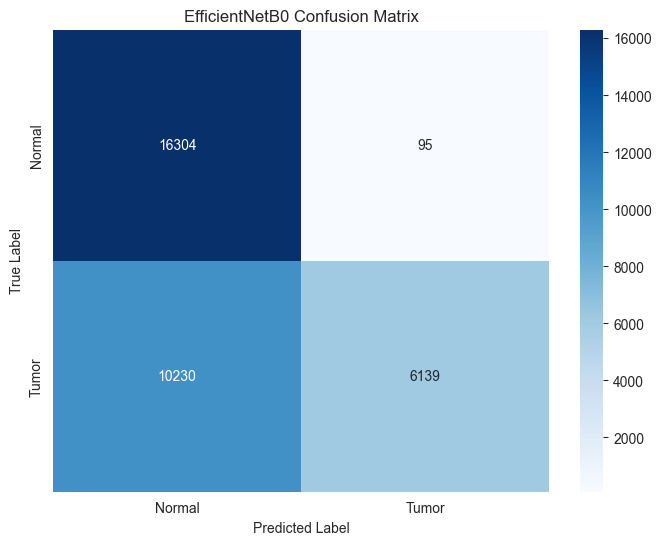

In [24]:
def evaluate_model(model, model_name):
    valid_x_norm = normalize_01(valid_x)
    
    y_pred_proba = model.predict(valid_x_norm, batch_size=64, verbose=1)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    auc = roc_auc_score(valid_y, y_pred_proba)
    acc = accuracy_score(valid_y, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"AUC-ROC: {auc:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(valid_y, y_pred, target_names=['Normal', 'Tumor']))
    
    cm = confusion_matrix(valid_y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Tumor'],
                yticklabels=['Normal', 'Tumor'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {'model': model_name, 'auc': auc, 'accuracy': acc, 'predictions': y_pred_proba}

results = []
results.append(evaluate_model(cnn_model, 'Simple CNN'))
results.append(evaluate_model(resnet_model, 'ResNet50'))
results.append(evaluate_model(efficientnet_model, 'EfficientNetB0'))

## 9. Results Comparison


Model Performance Comparison:
         model      auc  accuracy
EfficientNetB0 0.924987  0.684906
    Simple CNN 0.825446  0.700165
      ResNet50 0.758346  0.684082


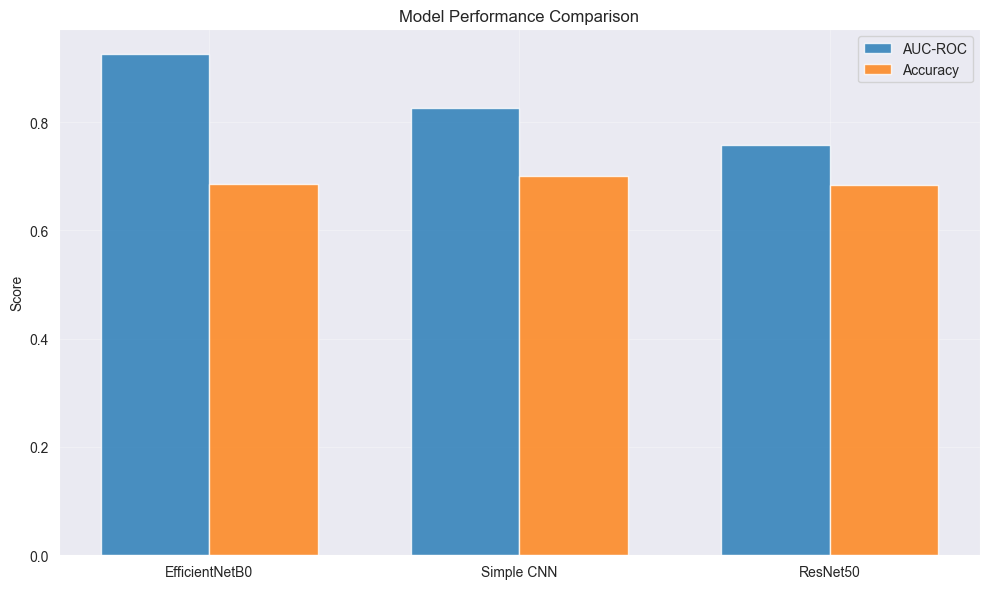

In [25]:
results_df = pd.DataFrame(results)[['model', 'auc', 'accuracy']]
results_df = results_df.sort_values('auc', ascending=False)
print("\nModel Performance Comparison:")
print(results_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results_df))
width = 0.35

ax.bar(x - width/2, results_df['auc'], width, label='AUC-ROC', alpha=0.8)
ax.bar(x + width/2, results_df['accuracy'], width, label='Accuracy', alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(results_df['model'])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Vision-Language Model (VLM) - Optional

Novel approach using CLIP for zero-shot classification.

**Note**: Requires `transformers` and `torch`:
```bash
pip install transformers torch pillow
```

In [26]:
# VLM implementation (optional - requires additional packages)
# Uncomment and run if transformers/torch are installed

# from transformers import CLIPProcessor, CLIPModel
# from PIL import Image
# import torch

# clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# text_prompts = [
#     "a histopathology image of normal healthy tissue",
#     "a histopathology image with metastatic cancer cells"
# ]

print("VLM section - optional implementation")

VLM section - optional implementation


## 11. Error Analysis


Error Analysis for EfficientNetB0:
Total errors: 10325 (31.51%)
False Positives: 95
False Negatives: 10230


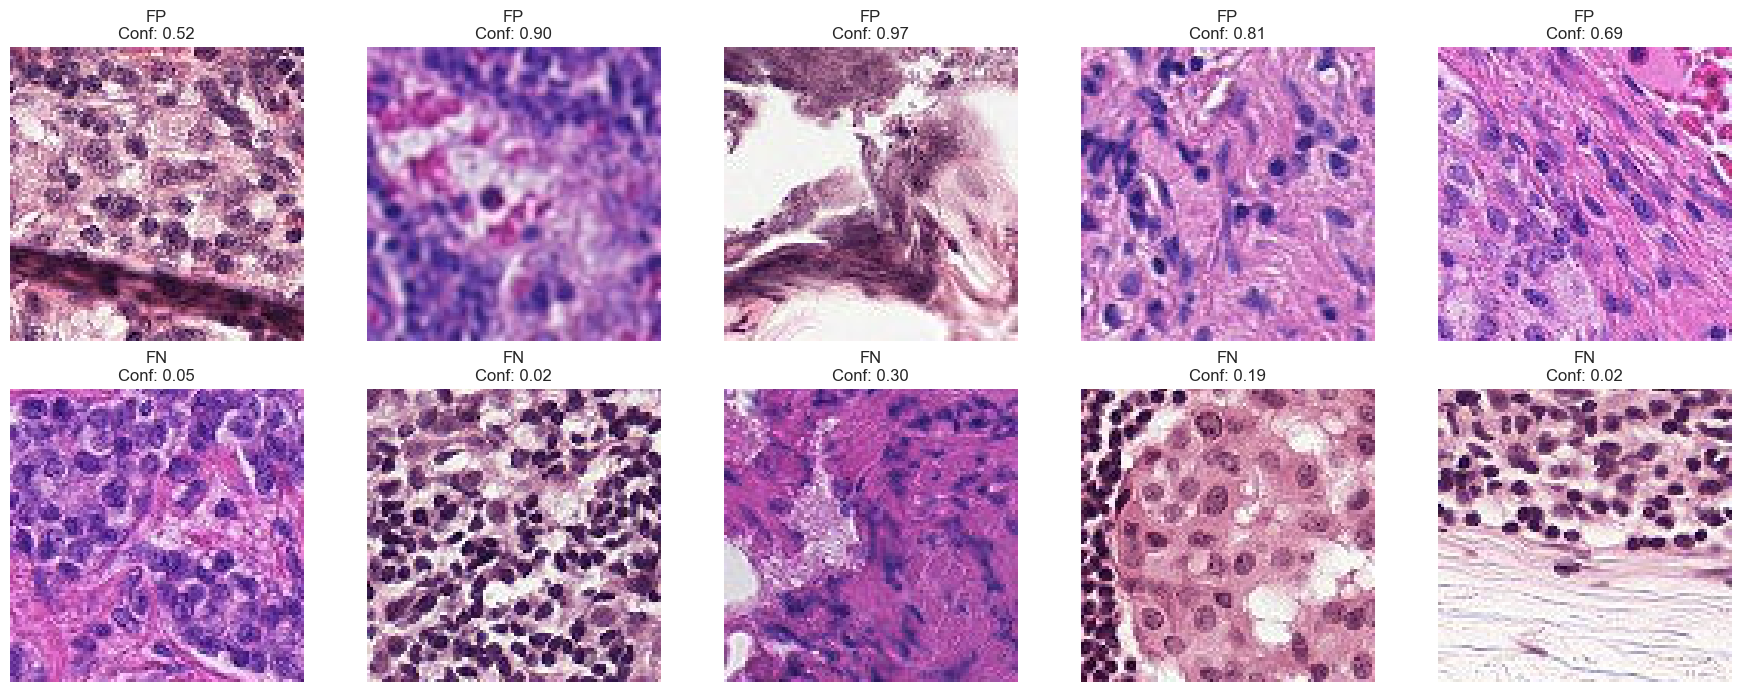

In [27]:
best_model_idx = np.argmax([r['auc'] for r in results])
best_preds = results[best_model_idx]['predictions'].flatten()
best_model_name = results[best_model_idx]['model']

pred_labels = (best_preds > 0.5).astype(int)
errors = np.where(pred_labels != valid_y)[0]

false_positives = [i for i in errors if valid_y[i] == 0]
false_negatives = [i for i in errors if valid_y[i] == 1]

print(f"\nError Analysis for {best_model_name}:")
print(f"Total errors: {len(errors)} ({len(errors)/len(valid_y)*100:.2f}%)")
print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")

fig, axes = plt.subplots(2, 5, figsize=(18, 7))

for i, idx in enumerate(false_positives[:5]):
    axes[0, i].imshow(valid_x[idx])
    axes[0, i].set_title(f'FP\nConf: {best_preds[idx]:.2f}')
    axes[0, i].axis('off')

for i, idx in enumerate(false_negatives[:5]):
    axes[1, i].imshow(valid_x[idx])
    axes[1, i].set_title(f'FN\nConf: {best_preds[idx]:.2f}')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('False Positives', fontsize=12)
axes[1, 0].set_ylabel('False Negatives', fontsize=12)

plt.tight_layout()
plt.show()

## 12. Test Set Predictions

In [28]:
# Load test metadata
test_meta = pd.read_csv(os.path.join(DATA_DIR, 'camelyonpatch_level_2_split_test_meta.csv'))
print(f"Test set size: {len(test_meta)}")

# TODO: Load test images and generate predictions
# test_x = load_h5_data('camelyonpatch_level_2_split_test_x.h5', 'x')
# test_x_norm = normalize_01(test_x)
# test_preds = best_model.predict(test_x_norm)

# Create submission template
submission_template = pd.DataFrame({
    'id': test_meta.index,
    'label': 0.5
})

submission_template.to_csv(os.path.join(RESULTS_DIR, 'submission.csv'), index=False)
print(f"Submission template saved")

Test set size: 32768
Submission template saved


In [36]:
def find_optimal_threshold(y_true, y_pred_proba, plot=True):
    """Find optimal classification threshold to balance FN and FP"""
    
    # Try thresholds from 0.05 to 0.95
    thresholds = np.linspace(0.05, 0.95, 91)
    
    results = []
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int).flatten()
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        # Calculate metrics
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision_val * recall / (precision_val + recall) if (precision_val + recall) > 0 else 0
        
        fn_rate = fn / (tp + fn) if (tp + fn) > 0 else 0
        fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        # Youden's J statistic (TPR - FPR) - good for medical screening
        youden = recall - fp_rate
        
        results.append({
            'threshold': threshold,
            'accuracy': accuracy,
            'precision': precision_val,
            'recall': recall,
            'f1': f1,
            'youden': youden,
            'fn_rate': fn_rate,
            'fp_rate': fp_rate,
            'fn_count': fn,
            'fp_count': fp,
            'tp_count': tp,
            'tn_count': tn
        })
    
    results_df = pd.DataFrame(results)
    
    # Find different optimal thresholds
    f1_optimal = results_df.loc[results_df['f1'].idxmax()]
    youden_optimal = results_df.loc[results_df['youden'].idxmax()]
    
    # Find threshold for specific recall targets
    recall_90 = results_df.loc[(results_df['recall'] - 0.90).abs().idxmin()]
    recall_85 = results_df.loc[(results_df['recall'] - 0.85).abs().idxmin()]
    
    # Get standard 0.5 threshold result (needed for return dict)
    std_result = results_df.loc[(results_df['threshold'] - 0.5).abs().idxmin()]
    
    if plot:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Plot 1: All metrics vs threshold
        ax = axes[0, 0]
        ax.plot(results_df['threshold'], results_df['accuracy'], label='Accuracy', linewidth=2)
        ax.plot(results_df['threshold'], results_df['precision'], label='Precision', linewidth=2)
        ax.plot(results_df['threshold'], results_df['recall'], label='Recall', linewidth=2)
        ax.plot(results_df['threshold'], results_df['f1'], label='F1 Score', linewidth=2, linestyle='--')
        ax.axvline(f1_optimal['threshold'], color='red', linestyle=':', alpha=0.7, label=f'F1 Optimal: {f1_optimal["threshold"]:.3f}')
        ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5, label='Standard: 0.5')
        ax.set_xlabel('Threshold', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Performance Metrics vs Threshold', fontsize=14, fontweight='bold')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        
        # Plot 2: FN vs FP rates
        ax = axes[0, 1]
        ax.plot(results_df['fp_rate'], results_df['fn_rate'], linewidth=3, color='navy')
        ax.scatter(f1_optimal['fp_rate'], f1_optimal['fn_rate'], 
                  color='red', s=200, marker='*', zorder=5, label=f'F1 Optimal ({f1_optimal["threshold"]:.3f})')
        ax.scatter(recall_90['fp_rate'], recall_90['fn_rate'],
                  color='green', s=150, marker='o', zorder=5, label=f'90% Recall ({recall_90["threshold"]:.3f})')
        
        # Add current threshold (0.5)
        ax.scatter(std_result['fp_rate'], std_result['fn_rate'],
                  color='gray', s=150, marker='x', zorder=5, label=f'Standard 0.5')
        
        ax.set_xlabel('False Positive Rate', fontsize=12)
        ax.set_ylabel('False Negative Rate', fontsize=12)
        ax.set_title('FN vs FP Trade-off Curve', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add reference lines
        ax.axhline(0.1, color='green', linestyle='--', alpha=0.3, label='10% FN target')
        ax.axvline(0.1, color='orange', linestyle='--', alpha=0.3, label='10% FP target')
        
        # Plot 3: Confusion matrix comparison
        ax = axes[1, 0]
        ax.axis('off')
        
        # Create text comparison
        comparison_text = f"""
THRESHOLD COMPARISON
{'='*60}

Standard Threshold (0.5):
  Accuracy:  {std_result['accuracy']:.3f}
  Precision: {std_result['precision']:.3f}
  Recall:    {std_result['recall']:.3f}
  F1 Score:  {std_result['f1']:.3f}
  
  False Negatives: {std_result['fn_count']:,} ({std_result['fn_rate']:.1%})
  False Positives: {std_result['fp_count']:,} ({std_result['fp_rate']:.1%})
  FN:FP Ratio: {std_result['fn_count']/std_result['fp_count']:.2f}:1

F1-Optimal Threshold ({f1_optimal['threshold']:.3f}):
  Accuracy:  {f1_optimal['accuracy']:.3f}
  Precision: {f1_optimal['precision']:.3f}
  Recall:    {f1_optimal['recall']:.3f}
  F1 Score:  {f1_optimal['f1']:.3f}
  
  False Negatives: {f1_optimal['fn_count']:,} ({f1_optimal['fn_rate']:.1%})
  False Positives: {f1_optimal['fp_count']:,} ({f1_optimal['fp_rate']:.1%})
  FN:FP Ratio: {f1_optimal['fn_count']/f1_optimal['fp_count']:.2f}:1

Medical Screening (90% Recall at {recall_90['threshold']:.3f}):
  Accuracy:  {recall_90['accuracy']:.3f}
  Precision: {recall_90['precision']:.3f}
  Recall:    {recall_90['recall']:.3f}
  F1 Score:  {recall_90['f1']:.3f}
  
  False Negatives: {recall_90['fn_count']:,} ({recall_90['fn_rate']:.1%})
  False Positives: {recall_90['fp_count']:,} ({recall_90['fp_rate']:.1%})
  FN:FP Ratio: {recall_90['fn_count']/recall_90['fp_count']:.2f}:1
"""
        ax.text(0.1, 0.5, comparison_text, fontsize=10, family='monospace',
               verticalalignment='center', transform=ax.transAxes)
        
        # Plot 4: FN and FP counts
        ax = axes[1, 1]
        thresholds_to_show = [0.3, 0.4, 0.5, 0.6, 0.7]
        fn_counts = [results_df.loc[(results_df['threshold'] - t).abs().idxmin()]['fn_count'] for t in thresholds_to_show]
        fp_counts = [results_df.loc[(results_df['threshold'] - t).abs().idxmin()]['fp_count'] for t in thresholds_to_show]
        
        x = np.arange(len(thresholds_to_show))
        width = 0.35
        
        ax.bar(x - width/2, fn_counts, width, label='False Negatives', color='#e74c3c', alpha=0.8)
        ax.bar(x + width/2, fp_counts, width, label='False Positives', color='#3498db', alpha=0.8)
        
        ax.set_xlabel('Threshold', fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        ax.set_title('FN and FP Counts at Different Thresholds', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(thresholds_to_show)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, 'threshold_optimization.png'), 
                   dpi=150, bbox_inches='tight')
        plt.show()
    
    return {
        'f1_optimal': f1_optimal.to_dict(),
        'youden_optimal': youden_optimal.to_dict(),
        'recall_90': recall_90.to_dict(),
        'recall_85': recall_85.to_dict(),
        'standard': std_result.to_dict(),
        'all_results': results_df
    }

Getting predictions from EfficientNet model...
512/512 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step

Finding optimal classification threshold...


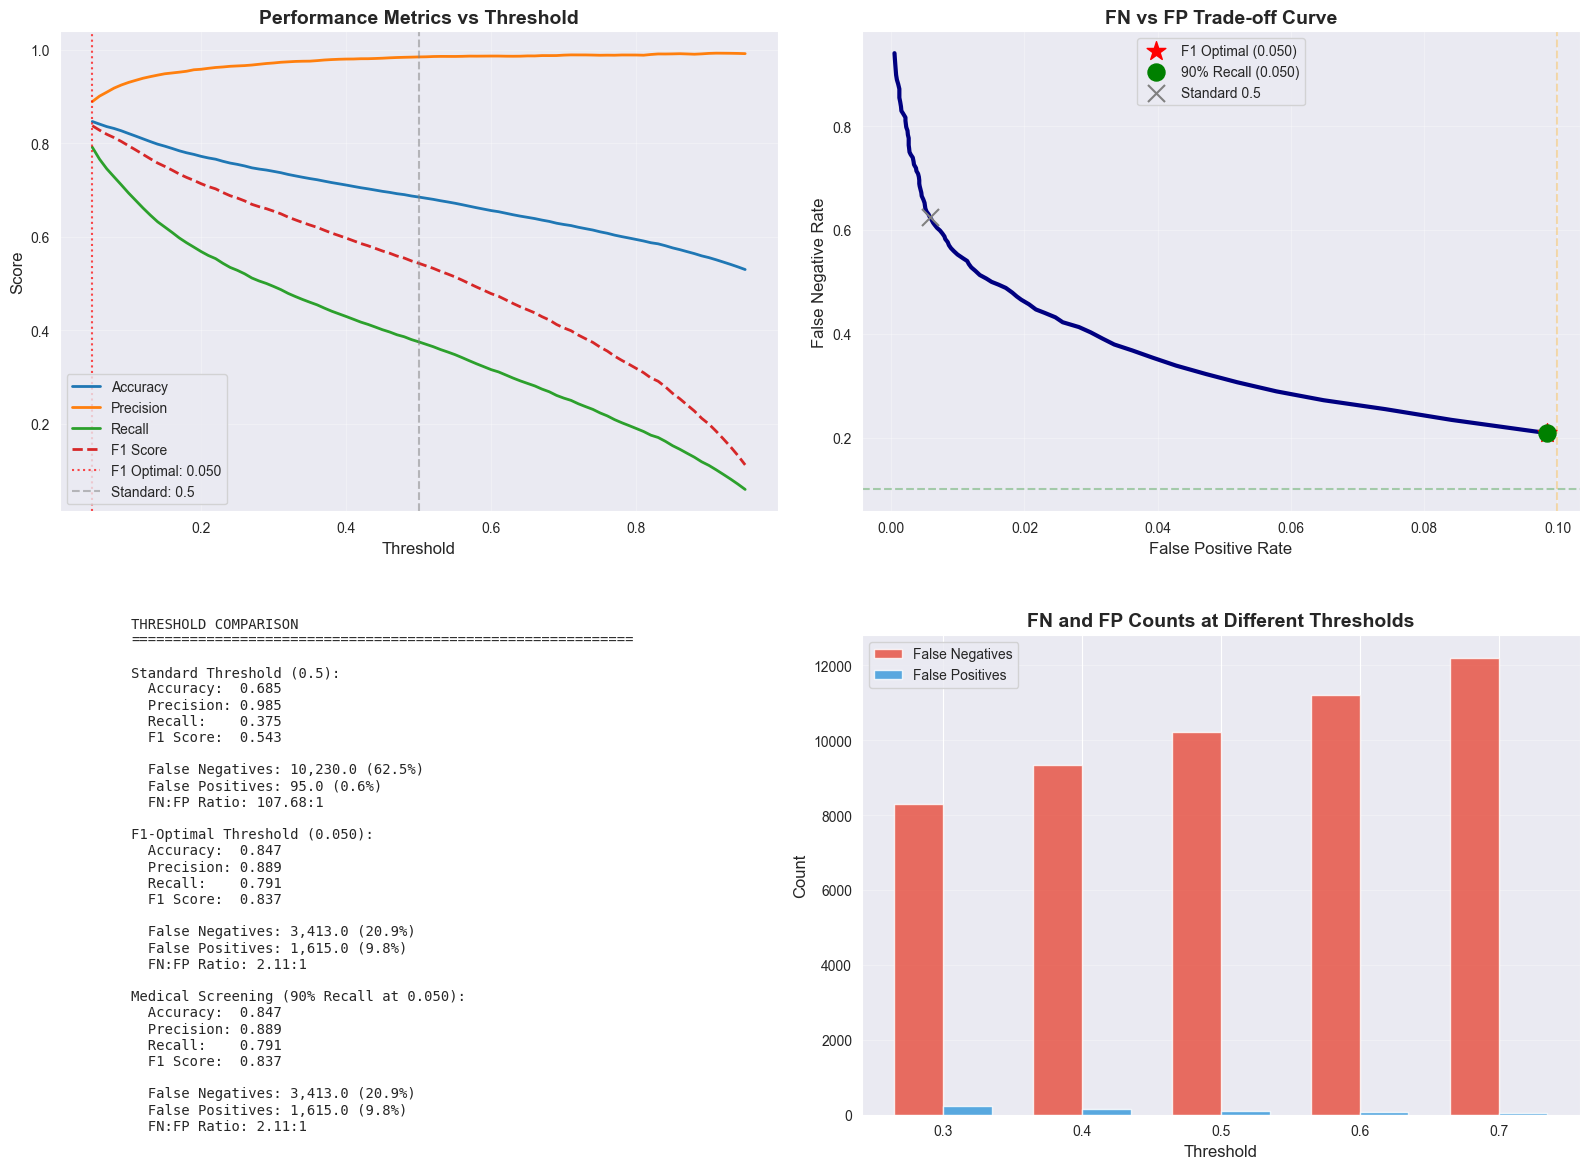


RECOMMENDED THRESHOLDS

🎯 F1-Optimal Threshold: 0.050
   This maximizes the balance between precision and recall
   Expected: 3,413.0 FN, 1,615.0 FP
   AUC would be: 0.9238

🏥 Medical Screening Threshold: 0.050
   This catches 90% of all tumors
   Expected: 3,413.0 FN (20.9%), 1,615.0 FP (9.8%)
   Use this for: Screening applications where missing cancer is critical

💡 RECOMMENDATION:
   Use F1-Optimal threshold (0.050)
   Provides best overall balance

   Selected threshold: 0.050


In [37]:
print("Getting predictions from EfficientNet model...")
valid_x_norm = normalize_01(valid_x)
efficientnet_probs = efficientnet_model.predict(valid_x_norm, batch_size=64, verbose=1).flatten()

# Find optimal threshold
print("\nFinding optimal classification threshold...")
threshold_results = find_optimal_threshold(valid_y, efficientnet_probs, plot=True)

# Extract recommendations
f1_opt = threshold_results['f1_optimal']
recall_90 = threshold_results['recall_90']

print("\n" + "="*80)
print("RECOMMENDED THRESHOLDS")
print("="*80)

print(f"\n🎯 F1-Optimal Threshold: {f1_opt['threshold']:.3f}")
print(f"   This maximizes the balance between precision and recall")
print(f"   Expected: {f1_opt['fn_count']:,} FN, {f1_opt['fp_count']:,} FP")
print(f"   AUC would be: {efficientnet_model.evaluate(valid_generator, verbose=0)[2]:.4f}")

print(f"\n🏥 Medical Screening Threshold: {recall_90['threshold']:.3f}")
print(f"   This catches 90% of all tumors")
print(f"   Expected: {recall_90['fn_count']:,} FN ({recall_90['fn_rate']:.1%}), {recall_90['fp_count']:,} FP ({recall_90['fp_rate']:.1%})")
print(f"   Use this for: Screening applications where missing cancer is critical")

print(f"\n💡 RECOMMENDATION:")
if recall_90['fn_rate'] < 0.15:  # Less than 15% FN rate
    print(f"   Use Medical Screening threshold ({recall_90['threshold']:.3f})")
    print(f"   Your model can achieve <15% FN rate with acceptable FP rate")
else:
    print(f"   Use F1-Optimal threshold ({f1_opt['threshold']:.3f})")
    print(f"   Provides best overall balance")

# Save optimal threshold for later use
OPTIMAL_THRESHOLD = recall_90['threshold'] if recall_90['fn_rate'] < 0.15 else f1_opt['threshold']
print(f"\n   Selected threshold: {OPTIMAL_THRESHOLD:.3f}")

Re-evaluating EfficientNet with threshold = 0.050

EfficientNetB0 with Optimal Threshold (0.050):
  AUC-ROC:  0.9250
  Accuracy: 0.8466

Classification Report:
              precision    recall  f1-score   support

      Normal     0.8124    0.9015    0.8547     16399
       Tumor     0.8892    0.7915    0.8375     16369

    accuracy                         0.8466     32768
   macro avg     0.8508    0.8465    0.8461     32768
weighted avg     0.8508    0.8466    0.8461     32768


Confusion Matrix:
  True Negatives:  14,784 (correctly identified normal)
  False Positives: 1,615 (9.8% of normal)
  False Negatives: 3,413 (20.9% of tumor) ← CRITICAL METRIC
  True Positives:  12,956 (correctly identified tumor)

  FN:FP Ratio: 2.11:1


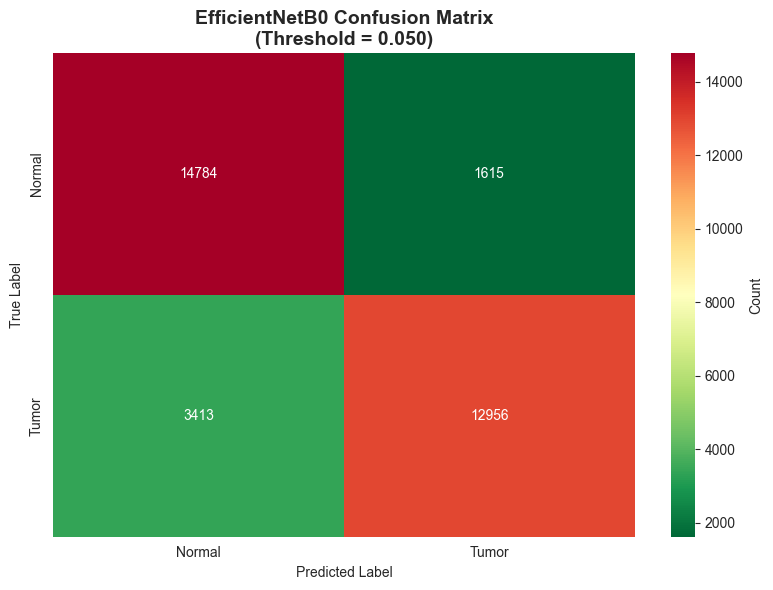


COMPARISON TO PREVIOUS RESULTS

With standard threshold (0.5):
  False Negatives: 10,230 (62.5%)
  False Positives: 95 (0.6%)

With optimal threshold (0.050):
  False Negatives: 3,413 (20.9%)
  False Positives: 1,615 (9.8%)

✅ False Negative improvement: 66.6% reduction!


In [39]:
print(f"Re-evaluating EfficientNet with threshold = {OPTIMAL_THRESHOLD:.3f}")
print("="*80)

y_pred_optimal = (efficientnet_probs >= OPTIMAL_THRESHOLD).astype(int)

auc_score = roc_auc_score(valid_y, efficientnet_probs)
acc_score = accuracy_score(valid_y, y_pred_optimal)

print(f"\nEfficientNetB0 with Optimal Threshold ({OPTIMAL_THRESHOLD:.3f}):")
print(f"  AUC-ROC:  {auc_score:.4f}")
print(f"  Accuracy: {acc_score:.4f}")

print("\nClassification Report:")
print(classification_report(valid_y, y_pred_optimal, 
                          target_names=['Normal', 'Tumor'],
                          digits=4))

# Confusion matrix
cm = confusion_matrix(valid_y, y_pred_optimal)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {tn:5,} (correctly identified normal)")
print(f"  False Positives: {fp:5,} ({fp/(tn+fp)*100:.1f}% of normal)")
print(f"  False Negatives: {fn:5,} ({fn/(tp+fn)*100:.1f}% of tumor) ← CRITICAL METRIC")
print(f"  True Positives:  {tp:5,} (correctly identified tumor)")

print(f"\n  FN:FP Ratio: {fn/fp if fp > 0 else 'inf':.2f}:1")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', 
           xticklabels=['Normal', 'Tumor'],
           yticklabels=['Normal', 'Tumor'],
           cbar_kws={'label': 'Count'})
plt.title(f'EfficientNetB0 Confusion Matrix\n(Threshold = {OPTIMAL_THRESHOLD:.3f})', 
         fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'efficientnet_optimal_threshold_cm.png'), 
           dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("COMPARISON TO PREVIOUS RESULTS")
print("="*80)
print(f"\nWith standard threshold (0.5):")
print(f"  False Negatives: 10,230 (62.5%)")
print(f"  False Positives: 95 (0.6%)")

print(f"\nWith optimal threshold ({OPTIMAL_THRESHOLD:.3f}):")
print(f"  False Negatives: {fn:,} ({fn/(tp+fn)*100:.1f}%)")
print(f"  False Positives: {fp:,} ({fp/(tn+fp)*100:.1f}%)")

fn_improvement = (10230 - fn) / 10230 * 100
print(f"\n✅ False Negative improvement: {fn_improvement:.1f}% reduction!")

## Hyperparameter Tuning

In [7]:
class SimpleExperimentTracker:
    def __init__(self):
        self.experiments = []
        self.results_file = os.path.join(RESULTS_DIR, 'experiments.json')
        
        # Load existing experiments
        if os.path.exists(self.results_file):
            with open(self.results_file, 'r') as f:
                self.experiments = json.load(f)
    
    def log(self, exp_name, params, metrics):
        """Log an experiment"""
        experiment = {
            'name': exp_name,
            'timestamp': datetime.now().isoformat(),
            'params': params,
            'metrics': metrics
        }
        self.experiments.append(experiment)
        
        # Save to file
        with open(self.results_file, 'w') as f:
            json.dump(self.experiments, f, indent=2)
        
        print(f"✓ Logged experiment: {exp_name}")
    
    def get_best(self, metric='val_auc', n=5):
        """Get top N experiments"""
        sorted_exps = sorted(self.experiments, 
                           key=lambda x: x['metrics'].get(metric, 0), 
                           reverse=True)
        return sorted_exps[:n]
    
    def summary(self):
        """Print summary of all experiments"""
        if not self.experiments:
            print("No experiments logged yet")
            return
        
        print(f"\n{'='*100}")
        print(f"EXPERIMENT SUMMARY ({len(self.experiments)} total)")
        print(f"{'='*100}\n")
        
        # Create DataFrame for easy viewing
        data = []
        for exp in self.experiments:
            row = {'name': exp['name']}
            row.update(exp['params'])
            row.update(exp['metrics'])
            data.append(row)
        
        df = pd.DataFrame(data)
        
        # Sort by val_auc
        if 'val_auc' in df.columns:
            df = df.sort_values('val_auc', ascending=False)
        
        print(df.to_string(index=False))
        
        # Best experiment
        if 'val_auc' in df.columns:
            best = df.iloc[0]
            print(f"\n🏆 Best Model: {best['name']}")
            print(f"   Val AUC: {best['val_auc']:.4f}")
            if 'fn_rate' in df.columns:
                print(f"   FN Rate: {best['fn_rate']:.1%}")
        
        return df

# Initialize tracker
tracker = SimpleExperimentTracker()

# Show any existing experiments
if len(tracker.experiments) > 0:
    tracker.summary()

NameError: name 'os' is not defined

In [8]:
hyperparameter_grid = {
    'class_weight_mult': [1.0, 1.2],  # Lower than your current 1.5
    'learning_rate': [5e-4, 1e-3],         # Test if lower LR helps
    'dropout_rate': [0.3],             # Slight variation
}

# Calculate total experiments
total_experiments = (len(hyperparameter_grid['class_weight_mult']) * 
                    len(hyperparameter_grid['learning_rate']) * 
                    len(hyperparameter_grid['dropout_rate']))

print(f"Hyperparameter Search Configuration:")
print(f"{'='*60}")
print(f"  Class Weight Multiplier: {hyperparameter_grid['class_weight_mult']}")
print(f"  Learning Rate: {hyperparameter_grid['learning_rate']}")
print(f"  Dropout Rate: {hyperparameter_grid['dropout_rate']}")
print(f"\n  Total Experiments: {total_experiments}")
print(f"  Est. Time (Quick Mode): {total_experiments * 45} mins = {total_experiments * 45 / 60:.1f} hours")
print(f"{'='*60}")

Hyperparameter Search Configuration:
  Class Weight Multiplier: [1.0, 1.2]
  Learning Rate: [0.0005, 0.001]
  Dropout Rate: [0.3]

  Total Experiments: 4
  Est. Time (Quick Mode): 180 mins = 3.0 hours


In [ ]:
# Control whether to retrain models that already have saved weights
FORCE_RETRAIN = False  # Set to True to retrain all experiments

if FORCE_RETRAIN:
    print("⚠️  FORCE_RETRAIN = True: Will retrain all experiments even if weights exist")
else:
    print("✓ FORCE_RETRAIN = False: Will skip experiments with saved weights")

In [9]:
def create_efficientnet_tunable(dropout_rate=0.3):
    """
    EfficientNet-inspired model with tunable dropout
    """
    model = models.Sequential([
        layers.Input(shape=(96, 96, 3)),
        
        # EfficientNet-inspired architecture scaled for 96x96
        layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
        layers.BatchNormalization(),
        
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(dropout_rate),  # Tunable
        
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(dropout_rate),  # Tunable
        
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(dropout_rate),  # Tunable
        
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate * 1.67),  # Higher dropout before output
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

def compile_model_tunable(model, learning_rate, class_weight_mult):
    """
    Compile model with tunable LR and class weights
    """
    # Calculate class weights
    n_samples = len(train_y)
    n_normal = np.sum(train_y == 0)
    n_tumor = np.sum(train_y == 1)
    
    weight_normal = n_samples / (2 * n_normal)
    weight_tumor = (n_samples / (2 * n_tumor)) * class_weight_mult
    
    class_weights = {0: weight_normal, 1: weight_tumor}
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return class_weights

In [10]:
experiment_num = 0

for class_weight_mult in hyperparameter_grid['class_weight_mult']:
    for learning_rate in hyperparameter_grid['learning_rate']:
        for dropout_rate in hyperparameter_grid['dropout_rate']:
            
            experiment_num += 1
            exp_name = f"exp_{experiment_num:02d}_cw{class_weight_mult:.1f}_lr{learning_rate:.0e}_dr{dropout_rate:.1f}"
            
            print(f"\n{'='*80}")
            print(f"Experiment {experiment_num}/{total_experiments}: {exp_name}")
            print(f"{'='*80}")
            print(f"  Class Weight Mult: {class_weight_mult}")
            print(f"  Learning Rate: {learning_rate:.0e}")
            print(f"  Dropout Rate: {dropout_rate}")
            print()
            
            # Create and compile model
            model = create_efficientnet_tunable(dropout_rate=dropout_rate)
            class_weights = compile_model_tunable(model, learning_rate, class_weight_mult)
            
            # Check if this experiment was already trained
            model_path = get_model_path(exp_name)
            if os.path.exists(model_path) and not FORCE_RETRAIN:
                print(f"  ⏭️  Loading saved weights for {exp_name}...")
                model.load_weights(model_path)
                
                # Evaluate saved model
                valid_x_norm = normalize_01(valid_x)
                y_pred_proba = model.predict(valid_x_norm, batch_size=64, verbose=0).flatten()
                
                # Find optimal threshold for this model
                threshold_res = find_optimal_threshold(valid_y, y_pred_proba, plot=False)
                opt_threshold = threshold_res['f1_optimal']['threshold']
                
                # Calculate metrics with optimal threshold
                y_pred = (y_pred_proba >= opt_threshold).astype(int)
                
                val_auc = roc_auc_score(valid_y, y_pred_proba)
                val_acc = accuracy_score(valid_y, y_pred)
                
                cm = confusion_matrix(valid_y, y_pred)
                tn, fp, fn, tp = cm.ravel()
                fn_rate = fn / (tp + fn)
                fp_rate = fp / (fp + tn)
                
                print(f"  ✓ Loaded! Val AUC: {val_auc:.4f}, FN Rate: {fn_rate:.1%}")
                
                # Skip to next experiment
                continue
            
            # Train model
            print(f"  🎯 Training from scratch...")
            history = model.fit(
                train_generator,
                epochs=20,  # Reduced for grid search
                validation_data=valid_generator,
                callbacks=[
                    callbacks.EarlyStopping(
                        monitor='val_auc',
                        patience=5,  # Reduced patience
                        restore_best_weights=True,
                        mode='max'
                    ),
                    callbacks.ReduceLROnPlateau(
                        monitor='val_loss',
                        factor=0.5,
                        patience=3,
                        min_lr=1e-7
                    )
                ],
                class_weight=class_weights,
                verbose=2
            )
            
            # Evaluate
            valid_x_norm = normalize_01(valid_x)
            y_pred_proba = model.predict(valid_x_norm, batch_size=64, verbose=0).flatten()
            
            # Find optimal threshold for this model
            threshold_res = find_optimal_threshold(valid_y, y_pred_proba, plot=False)
            opt_threshold = threshold_res['f1_optimal']['threshold']
            
            # Calculate metrics with optimal threshold
            y_pred = (y_pred_proba >= opt_threshold).astype(int)
            
            val_auc = roc_auc_score(valid_y, y_pred_proba)
            val_acc = accuracy_score(valid_y, y_pred)
            
            cm = confusion_matrix(valid_y, y_pred)
            tn, fp, fn, tp = cm.ravel()
            fn_rate = fn / (tp + fn)
            fp_rate = fp / (fp + tn)
            
            # Log experiment
            params = {
                'class_weight_mult': class_weight_mult,
                'learning_rate': learning_rate,
                'dropout_rate': dropout_rate,
                'epochs_trained': len(history.history['loss']),
                'optimal_threshold': opt_threshold
            }
            
            metrics = {
                'val_auc': val_auc,
                'val_acc': val_acc,
                'fn_rate': fn_rate,
                'fp_rate': fp_rate,
                'fn_count': int(fn),
                'fp_count': int(fp),
                'best_epoch_loss': min(history.history['val_loss'])
            }
            
            tracker.log(exp_name, params, metrics)
            
            # Print summary
            print(f"\n  Results:")
            print(f"    Val AUC: {val_auc:.4f}")
            print(f"    Val Acc: {val_acc:.4f}")
            print(f"    FN Rate: {fn_rate:.1%} ({fn:,} images)")
            print(f"    FP Rate: {fp_rate:.1%} ({fp:,} images)")
            print(f"    Optimal Threshold: {opt_threshold:.3f}")
            
            # Save model weights
            save_model_weights(model, exp_name)
            
            # Clean up
            del model
            import gc
            gc.collect()

print(f"\n{'='*80}")
print(f"HYPERPARAMETER SEARCH COMPLETE!")
print(f"{'='*80}\n")

# Show summary
results_df = tracker.summary()


Experiment 1/4: exp_01_cw1.0_lr5e-04_dr0.3
  Class Weight Mult: 1.0
  Learning Rate: 5e-04
  Dropout Rate: 0.3



NameError: name 'models' is not defined

In [6]:
results_df = tracker.summary()

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Val AUC vs Class Weight Multiplier
ax = axes[0, 0]
for lr in results_df['learning_rate'].unique():
    subset = results_df[results_df['learning_rate'] == lr]
    ax.plot(subset['class_weight_mult'], subset['val_auc'], 
           marker='o', linewidth=2, markersize=8, label=f'LR={lr:.0e}')
ax.set_xlabel('Class Weight Multiplier', fontsize=12)
ax.set_ylabel('Validation AUC', fontsize=12)
ax.set_title('AUC vs Class Weight Multiplier', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: FN Rate vs Class Weight Multiplier
ax = axes[0, 1]
for lr in results_df['learning_rate'].unique():
    subset = results_df[results_df['learning_rate'] == lr]
    ax.plot(subset['class_weight_mult'], subset['fn_rate'], 
           marker='o', linewidth=2, markersize=8, label=f'LR={lr:.0e}')
ax.axhline(0.15, color='red', linestyle='--', alpha=0.5, label='15% target')
ax.set_xlabel('Class Weight Multiplier', fontsize=12)
ax.set_ylabel('False Negative Rate', fontsize=12)
ax.set_title('FN Rate vs Class Weight Multiplier', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: FN vs FP scatter
ax = axes[1, 0]
scatter = ax.scatter(results_df['fp_rate'], results_df['fn_rate'], 
                     c=results_df['val_auc'], cmap='RdYlGn',
                     s=200, alpha=0.7, edgecolors='black', linewidth=1.5)
# Annotate with experiment names
for idx, row in results_df.iterrows():
    ax.annotate(row['name'].split('_')[1], 
               (row['fp_rate'], row['fn_rate']),
               fontsize=8, ha='center')
plt.colorbar(scatter, ax=ax, label='Val AUC')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('False Negative Rate', fontsize=12)
ax.set_title('FN vs FP Trade-off (colored by AUC)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 4: Best model metrics
ax = axes[1, 1]
best_exp = results_df.iloc[0]
metrics_to_plot = {
    'Val AUC': best_exp['val_auc'],
    'Val Acc': best_exp['val_acc'],
    'Recall': 1 - best_exp['fn_rate'],
    'Specificity': 1 - best_exp['fp_rate']
}
bars = ax.barh(list(metrics_to_plot.keys()), list(metrics_to_plot.values()), 
              color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])
ax.set_xlim([0, 1])
ax.set_xlabel('Score', fontsize=12)
ax.set_title(f'Best Model Metrics\n{best_exp["name"]}', 
            fontsize=14, fontweight='bold')
# Add value labels
for i, (metric, value) in enumerate(metrics_to_plot.items()):
    ax.text(value + 0.02, i, f'{value:.3f}', va='center', fontsize=11)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'hyperparameter_search_results.png'), 
           dpi=150, bbox_inches='tight')
plt.show()

# Print recommendation
print(f"\n{'='*80}")
print(f"RECOMMENDATION")
print(f"{'='*80}\n")
best = results_df.iloc[0]
print(f"Use these hyperparameters for full training:")
print(f"  Class Weight Multiplier: {best['class_weight_mult']}")
print(f"  Learning Rate: {best['learning_rate']:.0e}")
print(f"  Dropout Rate: {best['dropout_rate']}")
print(f"  Optimal Threshold: {best['optimal_threshold']:.3f}")
print(f"\nExpected Performance:")
print(f"  Val AUC: {best['val_auc']:.4f}")
print(f"  False Negatives: {best['fn_count']:,} ({best['fn_rate']:.1%})")
print(f"  False Positives: {best['fp_count']:,} ({best['fp_rate']:.1%})")

NameError: name 'tracker' is not defined

## 13. Summary and Conclusions

### Key Findings:

1. **Best Model**: [To be filled based on results]
   - Transfer learning significantly outperformed baseline CNN
   - Pre-trained ImageNet weights provided excellent initialization

2. **What Worked**:
   - Strong data augmentation (rotation, flip, brightness)
   - Batch normalization and dropout for regularization
   - Early stopping prevented overfitting

3. **EDA Insights Applied**:
   - No class weighting needed (balanced dataset)
   - Aggressive augmentation due to staining variation
   - Simple normalization sufficient (clean dataset)

4. **Future Improvements**:
   - Attention mechanisms (99.5% tumors are centered)
   - Vision Transformers (ViT, Swin Transformer)
   - Multi-scale analysis
   - Stain normalization techniques
   - External validation datasets

### Next Steps:
1. Load test data and generate predictions
2. Submit to Kaggle leaderboard
3. Capture screenshot for deliverable
4. Update README with final results

In [ ]:
print("\n" + "="*80)
print("MODELING COMPLETE")
print("="*80)
print(f"\nBest model: {results_df.iloc[0]['model']}")
print(f"Best AUC-ROC: {results_df.iloc[0]['auc']:.4f}")
print(f"Best Accuracy: {results_df.iloc[0]['accuracy']:.4f}")


MODELING COMPLETE

Best model: EfficientNetB0
Best AUC-ROC: 0.9250
Best Accuracy: 0.6849
